In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43201")
client

<Client: 'tcp://127.0.0.1:43201' processes=3 threads=3, memory=8.79 GiB>

In [3]:
import xarray as xr
import numpy as np
import os.path as op
import xrft
from scipy.interpolate import griddata
import scipy
from xmovie import Movie
import matplotlib.pyplot as plt
%matplotlib inline

/mnt/meom/workdir/legarrem/miniconda3/envs/meomstage/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ddir = '/mnt/meom/workdir/uchidat/Stage/LeGarrec'
savedir = '/mnt/meom/workdir/legarrem/'

# Read the data file

In [5]:
dst = xr.open_zarr(op.join(ddir,'SST_15N-50N.zarr'))
dst

<xarray.Dataset>
Dimensions:  (YC: 423, XC: 1000, nmemb: 48, time: 36, XG: 1000, YG: 423)
Coordinates: (12/29)
    Depth    (YC, XC) float32 dask.array<chunksize=(212, 500), meta=np.ndarray>
    PHrefC   float32 ...
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * XG       (XG) float32 262.0 262.0 262.1 262.2 ... 347.7 347.8 347.8 347.9
  * YC       (YC) float32 14.92 15.0 15.08 15.17 ... 49.83 49.92 50.0 50.08
  * YG       (YG) float32 14.96 15.04 15.13 15.21 ... 49.88 49.96 50.04 50.13
    ...       ...
    maskW    (YC, XG) int8 dask.array<chunksize=(212, 1000), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(212, 500), meta=np.ndarray>
    rAs      (YG, XC) float32 dask.array<chunksize=(212, 500), meta=np.ndarray>
    rAw      (YC, XG) float32 dask.array<chunksize=(212, 500), meta=np.ndarray>
    rhoRef   float32 ...
  * time     (time) timedelta64[ns] 3290 days 3295 days ... 3550 days 3555 days
Dimensions without coordinates: nmemb
Data variables:
    THETA    (nmemb, time, YC, XC) float32 dask.array<chunksize=(6, 5, 106, 250), meta=np.ndarray>

The time dimension has 36 slices. They consist of 5-day averaged simulation outputs for the winter and summer months of 1967 (i.e. Jan., Feb., Mar. and Jul., Aug., Sep. respectively).

# Compute the ensemble mean and residual from it

In [6]:
Tb = dst.THETA.mean('nmemb',skipna=True)   # Mean over the ensemble dimension
Tp = dst.THETA - Tb                        # Residual from the ensemble mean
# print(Tb, Tp)

size_X = dst.XC.size
size_Y = dst.YC.size
size_t = dst.time.size
size_n = dst.nmemb.size

## I. σ²(t)

In [22]:
Tstd = dst.THETA.std('nmemb',skipna=True) # Standard deviation over the ensemble dimension
Tvar = dst.THETA.var('nmemb',skipna=True)
A = dst.rA.sum()

In [69]:
Integrate_Var_time = (Tvar*dst.rA).sum(['XC', 'YC']) #Variance over the ensemble dimension
Var_t = Integrate_Var_time/A
Var_t

<xarray.DataArray (time: 36)>
dask.array<truediv, shape=(36,), dtype=float32, chunksize=(5,), chunktype=numpy.ndarray>
Coordinates:
    PHrefC   float32 29.89
    Z        float32 -3.047
    Zl       float32 0.0
    Zu       float32 -6.094
    drF      float32 6.094
    iter     (time) int64 dask.array<chunksize=(36,), meta=np.ndarray>
    rhoRef   float32 1.021e+03
  * time     (time) timedelta64[ns] 3290 days 3295 days ... 3550 days 3555 days

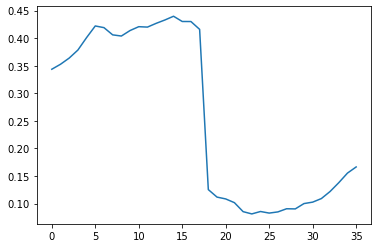

In [71]:
time = range(0, size_t)
plt.plot(time, Var_t)
plt.savefig(op.join(savedir,'imageVart.png'))

##### Try FFT

In [10]:
"""
grid_t = np.mgrid[0:size_t]
ip_data_time = griddata(grid_t, Var_t, grid_t, method='cubic')
plt.figure(figsize=(10,4))
plt.plot(ip_data_time)"""

"\nip_data_time = griddata(grid_t, Var_t, grid_t, method='cubic')\nplt.figure(figsize=(10,4))\nplt.plot(ip_data_time)"

In [11]:
"""xrI = xr.DataArray(ip_data_time, coords=[grid_t], dims="t")
fftI = xrft.fft(xrI, dims="t", true_phase=True, true_amplitude=True)"""

NameError: name 'ip_data_time' is not defined

In [ ]:
"""(fftI*np.conj(fftI)).real.plot(figsize=(10,4))
plt.xlim(-0.5,0.5)"""

## II. Power Spectrum

### a. Regular grid

#### a.1 All map

In [6]:
#non-uniform grid in km
m_x = np.cumsum(dst.dxC.values, axis = 1)/1000
m_y = np.cumsum(dst.dyC.values, axis = 0)/1000
m_grid = np.dstack([m_y, m_x]).reshape(-1, 2)

In [7]:
size_toplat = int(np.ceil(m_x[-1][-1])) #6140 size of the the northern latitude in km 
size_lon = int(np.ceil(m_y[-1][-1])) #3919 size of the (last) longitude in km

In [8]:
diff_N = size_toplat - m_x[-1][0]
diff_S = m_x[0][-1] - m_x[0][0]
N_S_diff = diff_S - diff_N #-> 3102.2614 km

In [9]:
#diff = m_x[0][-1] - m_x[-1][-1] #3105.9956 difference between northern latitude size and southern latitude size 
first_x =  int(np.floor(m_x[0][0] + N_S_diff/2)) #1560 first X value at northern latitude 
first_y = int(np.floor(m_y[0][0])) #9 first value of longitude

In [10]:
#uniform grid in km (high resolution)
uni_step = 3
grid_x, grid_y = np.mgrid[first_y:size_lon:uni_step, first_x:size_toplat:uni_step]

#### a.2 Regular Sliced grid

In [11]:
sliced_data = dst.sel(YG=slice(35,50), XG=slice(310,330)).sel(YC=slice(35,50), XC=slice(310,330)).where(dst.maskInC!=0.)
sliced_data = sliced_data.isel(XC=slice(0,sliced_data.XG.size))

In [12]:
#sliced_data = sliced_data.isel(XC=slice(0,sliced_data.XG.size))

In [13]:
#non-uniform grid in km
ms_x = np.cumsum(sliced_data.dxC.values, axis = 1)/1000
ms_y = np.cumsum(sliced_data.dyC.values, axis = 0)/1000
ms_grid = np.dstack([ms_y, ms_x]).reshape(-1, 2)

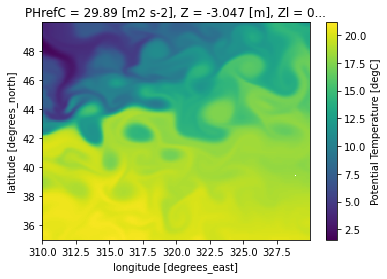

In [14]:
sliced_data.THETA.isel(nmemb=0,time=0).plot(rasterized=True, cmap="viridis")

In [10]:
ssize_toplat = int(np.ceil(ms_x[-1][-1])) #size of the the northernmost latitude in km 
ssize_lon = int(np.ceil(ms_y[-1][-1])) #size of one longitude in km

In [11]:
sdiff_N = ssize_toplat - ms_x[-1][0]
sdiff_S = ms_x[0][-1] - ms_x[0][0]
N_S_sdiff = sdiff_S - sdiff_N

In [12]:
first_sx =  int(np.floor(ms_x[0][0] + N_S_sdiff/2))  
first_sy = int(np.floor(ms_y[0][0]))

In [13]:
#uniform grid in km 
sstep = 10
grid1_x, grid1_y = np.mgrid[first_sy:ssize_lon:sstep, first_sx:ssize_toplat:sstep]

### b. Interpolate the regular grid

#### All map

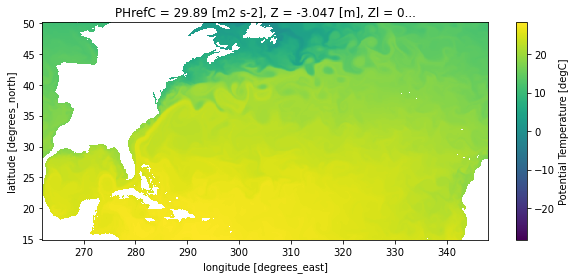

In [12]:
values = dst.THETA.isel(nmemb=0,time=0).where(dst.maskInC!=False)
plt.figure(figsize=(10,4))
values.plot(rasterized=True, cmap='viridis')

In [13]:
ip_data = griddata(m_grid, values.values.flatten(), (grid_x, grid_y), method='nearest')

In [14]:
x_values = grid_y[0] #Values in km on X-axis from uniform grid
y_values = (grid_x.T)[0] #Values in km on Y-axis from uniform grid

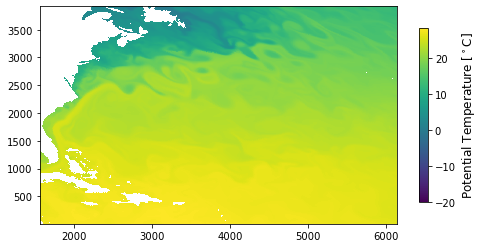

In [15]:
fig, ax = plt.subplots(figsize=(8,4))
im = ax.pcolormesh(x_values, y_values, ip_data, cmap='viridis', vmin=-20)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label(r"Potential Temperature [$^\circ$C]", fontsize=12)

##### Time dimension (nmemb=0) / 106s to fill the array (3km step)

In [15]:
size_y = (grid_x.T)[0].size
size_x = grid_y[0].size

In [16]:
y_3Dchunk = int(size_y/4)
x_3Dchunk = int(size_x/4)
t_3Dchunk = int(size_t/6)

In [17]:
n_data = xr.DataArray(np.zeros((size_t, size_y, size_x)), dims=["time", "Ym", "Xm"], coords=dict(time=(["time"], dst.time.values), 
                                                                                                  Ym=(["Ym"], (grid_x.T)[0]), 
                                                                                                  Xm=(["Xm"], grid_y[0])))
n_data.chunk((t_3Dchunk, y_3Dchunk, x_3Dchunk))

<xarray.DataArray (time: 36, Ym: 1304, Xm: 1527)>
dask.array<xarray-<this-array>, shape=(36, 1304, 1527), dtype=float64, chunksize=(6, 326, 381), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) timedelta64[ns] 3290 days 3295 days ... 3550 days 3555 days
  * Ym       (Ym) int64 9 12 15 18 21 24 27 ... 3903 3906 3909 3912 3915 3918
  * Xm       (Xm) int64 1560 1563 1566 1569 1572 ... 6126 6129 6132 6135 6138

In [18]:
n_data[0] = ip_data

In [19]:
for i in range(1,int(size_t)):
        i_values = dst.THETA.isel(nmemb=0,time=i).where(dst.maskInC!=False).values.flatten()
        n_data[i] = griddata(m_grid, i_values, (grid_x, grid_y), method='nearest')

In [20]:
n_data

<xarray.DataArray (time: 36, Ym: 1304, Xm: 1527)>
array([[[        nan,         nan,         nan, ..., 26.16293335,
         26.15171051, 26.15171051],
        [        nan,         nan,         nan, ..., 26.16293335,
         26.15171051, 26.15171051],
        [        nan,         nan,         nan, ..., 26.09903526,
         26.09903526, 26.09903526],
        ...,
        [        nan,         nan,         nan, ..., 11.63032627,
         11.57787228, 11.57787228],
        [        nan,         nan,         nan, ..., 11.54602337,
         11.54602337, 11.49545288],
        [        nan,         nan,         nan, ..., 11.54602337,
         11.54602337, 11.49545288]],

       [[        nan,         nan,         nan, ..., 26.03034782,
         26.01117134, 26.01117134],
        [        nan,         nan,         nan, ..., 26.03034782,
         26.01117134, 26.01117134],
        [        nan,         nan,         nan, ..., 25.93392181,
         25.93392181, 25.93392181],
...
        [        nan,         nan,         nan, ..., 15.86372948,
         15.83903313, 15.83903313],
        [        nan,         nan,         nan, ..., 15.75487804,
         15.75487804, 15.72597599],
        [        nan,         nan,         nan, ..., 15.75487804,
         15.75487804, 15.72597599]],

       [[        nan,         nan,         nan, ..., 27.72630119,
         27.7120285 , 27.7120285 ],
        [        nan,         nan,         nan, ..., 27.72630119,
         27.7120285 , 27.7120285 ],
        [        nan,         nan,         nan, ..., 27.6720314 ,
         27.6720314 , 27.6720314 ],
        ...,
        [        nan,         nan,         nan, ..., 15.79926491,
         15.77219868, 15.77219868],
        [        nan,         nan,         nan, ..., 15.68669796,
         15.68669796, 15.65324211],
        [        nan,         nan,         nan, ..., 15.68669796,
         15.68669796, 15.65324211]]])
Coordinates:
  * time     (time) timedelta64[ns] 3290 days 3295 days ... 3550 days 3555 days
  * Ym       (Ym) int64 9 12 15 18 21 24 27 ... 3903 3906 3909 3912 3915 3918
  * Xm       (Xm) int64 1560 1563 1566 1569 1572 ... 6126 6129 6132 6135 6138

#### Sliced map

In [14]:
x1_values = grid1_y[0] #Values in km on X-axis from uniform grid
y1_values = (grid1_x.T)[0] #Values in km on Y-axis from uniform grid

size_y1 = y1_values.size
size_x1 = x1_values.size

In [15]:
n_data = xr.DataArray(np.zeros((size_n, size_t, size_y1, size_x1)), dims=["nmemb", "time", "Ym", "Xm"], 
                      coords=dict(nmemb=(["nmemb"], dst.nmemb.values), 
                                  time=(["time"], dst.time.values), 
                                  Ym=(["Ym"], y1_values), 
                                  Xm=(["Xm"], x1_values)))
n_data.chunk({'nmemb':6,'time':6})

<xarray.DataArray (nmemb: 48, time: 36, Ym: 166, Xm: 123)>
dask.array<xarray-<this-array>, shape=(48, 36, 166, 123), dtype=float64, chunksize=(6, 6, 166, 123), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 38 39 40 41 42 43 44 45 46 47
  * time     (time) timedelta64[ns] 3290 days 3295 days ... 3550 days 3555 days
  * Ym       (Ym) int64 9 19 29 39 49 59 69 ... 1609 1619 1629 1639 1649 1659
  * Xm       (Xm) int64 201 211 221 231 241 251 ... 1381 1391 1401 1411 1421

In [16]:
for j in range(0, int(size_n)):
    for i in range(0,int(size_t)):
            ji_values = sliced_data.THETA.isel(nmemb=j,time=i).values.flatten()
            n_data[j][i] = griddata(ms_grid, ji_values, (grid1_x, grid1_y), method='nearest')

In [17]:
n_data.to_dataset(name='THETA').to_zarr(op.join(savedir,'ip_sliced_data.zarr'), mode="w")

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.pcolormesh(x1_values, y1_values, n_data[0][0], cmap='viridis', vmin=4)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label(r"Potential Temperature [$^\circ$C]", fontsize=12)

### c. Power spectra (on sliced map) 

#### 0. Sliced map

In [6]:
datac = xr.open_zarr(op.join(savedir,'ip_sliced_data.zarr'))

In [7]:
s_map = datac #.isel(Ym=slice(0, min(datac.Xm.values.size, datac.Ym.values.size))) 
s_map.THETA.shape

(48, 36, 166, 123)

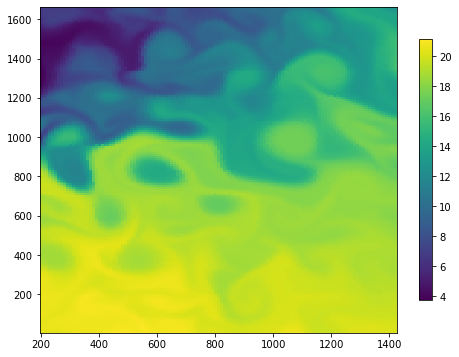

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.pcolormesh(s_map.Xm.values, s_map.Ym.values, s_map.THETA[0][0], cmap='viridis')
#ax.set_aspect('equal')
cbar = fig.colorbar(im, ax=ax, shrink=.8)

#### 1. 2D Window (to improve signal clarity)

In [9]:
window1dX = scipy.signal.windows.hann(datac.Xm.values.size, False)
window1dY = scipy.signal.windows.hann(datac.Ym.values.size, False)
window2d = np.sqrt(np.outer(window1dY,window1dX))

In [10]:
window2d.shape

(166, 123)

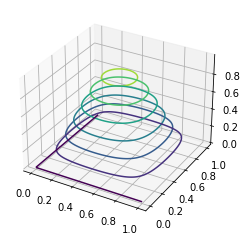

In [11]:
fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.linspace(0, 1, datac.Xm.values.size)
y = np.linspace(0, 1, datac.Ym.values.size)

X, Y = np.meshgrid(x, y)
ax.contour3D(X, Y, window2d, cmap='viridis')
plt.savefig(op.join(savedir,'imageHann.png'))

In [12]:
W_smap = xr.DataArray((window2d*s_map).to_array('THETA')[0], dims=["nmemb", "time", "Ym", "Xm"], 
                      coords=dict(nmemb=(["nmemb"], s_map.nmemb.values), 
                                  time=(["time"], s_map.time.values), 
                                  Ym=(["Ym"], s_map.Ym.values), 
                                  Xm=(["Xm"], s_map.Xm.values)))
W_smap = W_smap.chunk((6, 6, s_map.Ym.size, s_map.Xm.values.size))

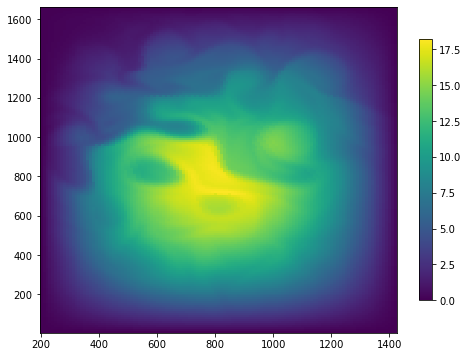

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.pcolormesh(s_map.Xm.values, s_map.Ym.values, W_smap[0][0], cmap='viridis')
#ax.set_aspect('equal')
cbar = fig.colorbar(im, ax=ax, shrink=.8)

#### 2. Power Spectrum 2D

##### Raw Power Spectrum

In [31]:
PSpectra = xrft.power_spectrum(s_map.to_array('THETA')[0].chunk((6,6, s_map.Ym.size, s_map.Xm.values.size)), dim=['Ym', 'Xm']) 

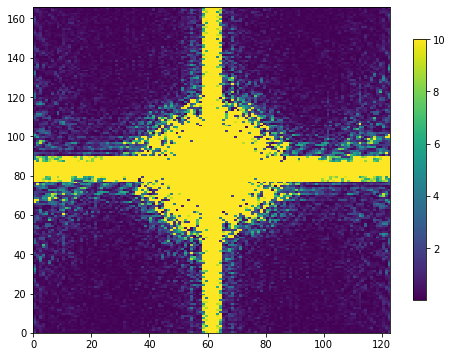

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.pcolormesh(PSpectra[0][0], cmap='viridis', vmax=10e0, vmin=10e-6)
#ax.set_aspect('equal')
cbar = fig.colorbar(im, ax=ax, shrink=.8)

##### Windowed power spectrum 2D

In [14]:
WPSpectra = xrft.power_spectrum(W_smap, dim=['Ym', 'Xm'])

In [15]:
WPSpectra

<xarray.DataArray 'rechunk-merge-73e2ad71b7d9d46eba6cbe74a326cb59' (nmemb: 48,
                                                                    time: 36,
                                                                    freq_Ym: 166,
                                                                    freq_Xm: 123)>
dask.array<mul, shape=(48, 36, 166, 123), dtype=float64, chunksize=(6, 6, 166, 123), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 38 39 40 41 42 43 44 45 46 47
  * time     (time) timedelta64[ns] 3290 days 3295 days ... 3550 days 3555 days
  * freq_Ym  (freq_Ym) float64 -0.05 -0.0494 -0.0488 ... 0.04819 0.0488 0.0494
  * freq_Xm  (freq_Xm) float64 -0.04959 -0.04878 -0.04797 ... 0.04878 0.04959

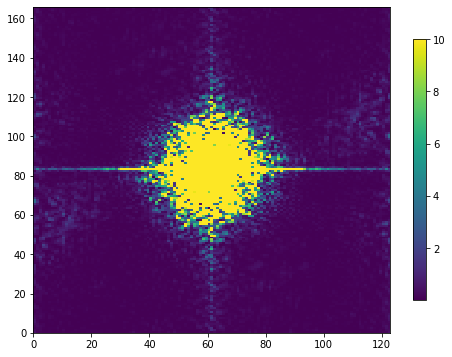

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.pcolormesh(WPSpectra[0][0], cmap='viridis', vmax=10e0, vmin=10e-6)
#ax.set_aspect('equal')
cbar = fig.colorbar(im, ax=ax, shrink=.8)

#### 3. Windowed Isotropic power spectrum

##### Using argument window

In [16]:
window = "hann"

In [17]:
isoPS = xrft.isotropic_power_spectrum(s_map.to_array('THETA')[0].chunk((6, 6, s_map.Ym.size, s_map.Xm.values.size)), dim=['Ym', 'Xm'], window=window, window_correction=True, truncate=True)
isoPS

<xarray.DataArray (nmemb: 48, time: 36, freq_r: 21)>
dask.array<getitem, shape=(48, 36, 21), dtype=float64, chunksize=(6, 6, 21), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 38 39 40 41 42 43 44 45 46 47
  * time     (time) timedelta64[ns] 3290 days 3295 days ... 3550 days 3555 days
    THETA    <U5 'THETA'
  * freq_r   (freq_r) float64 0.001449 0.003552 0.005896 ... 0.04576 0.04811

In [18]:
isoPSwinter = isoPS.isel(time=slice(0,int((size_t/2)-1)))
isoPSsummer = isoPS.isel(time=slice(int(size_t/2), size_t))

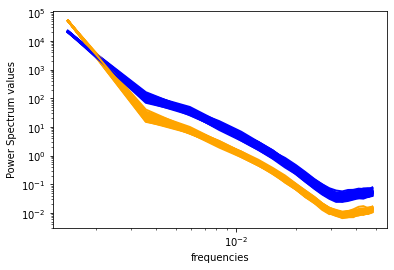

In [19]:
fig, ax = plt.subplots()
winter_line = ax.plot(isoPS.freq_r, isoPSwinter.mean(['nmemb','time']), lw=2, color="blue")
summer_line = ax.plot(isoPS.freq_r, isoPSsummer.mean(['nmemb','time']), lw=2, color="orange")

plt.ylabel('Power Spectrum values')
plt.xlabel('wavenumber')
ax.set_xscale('log')
ax.set_yscale('log')

#legend = ax.legend(loc='upper right')
plt.show()
fig.savefig(op.join(savedir,'imagePS.png'))

##### Windowed isotropic power spectrum

In [44]:
isoPS1 = xrft.isotropic_power_spectrum(W_smap, dim=['Ym', 'Xm'], truncate=True)

In [45]:
isoPSwinter1 = isoPS1.isel(time=slice(0,int((size_t/2)-1)))
isoPSsummer1 = isoPS1.isel(time=slice(int(size_t/2), size_t))

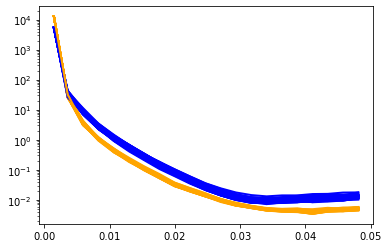

In [47]:
fig, ax = plt.subplots()
for i in range(size_t):
    winter_line1 = ax.plot(isoPS1.freq_r, isoPSwinter1.isel(nmemb=i).mean('time'), lw=2, color="blue")
    summer_line1 = ax.plot(isoPS1.freq_r, isoPSsummer1.isel(nmemb=i).mean('time'), lw=2, color="orange")
    
#ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

### Exercices

#### Exercice 1 : Discrete Fourier Transformation 1D

In [ ]:
x = np.linspace(0,10,1001)
da = xr.DataArray(np.sin(2*np.pi*2*x), dims='x', coords={'x':x})
da.plot(figsize=(10,4))

##### Power Spectrum function

In [ ]:
P1 = xrft.power_spectrum(da, dim='x')
P1.plot(figsize=(10,4))
plt.xlim(-5,5)

In [ ]:
xrft.ifft(P1, dim='freq_x', true_phase=True, true_amplitude=True, lag=5).real.plot(figsize=(10,4))

##### Discrete Fourier Transformation (!! only 1 dimension)

In [ ]:
P2 = xrft.fft(da, dim='x', true_phase=True, true_amplitude=True)
P2.real.plot(figsize=(10,4))
plt.xlim(-5,5)

In [ ]:
P3 = xrft.ifft(P2, dim='freq_x', true_phase=True, true_amplitude=True, lag=5)
P3.real.plot(figsize=(10,4))

#### Exercice 2 : Interpolation and Discrete Fourier Transformation 1D

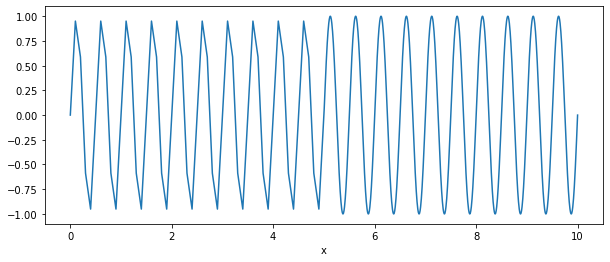

In [41]:
x = np.concatenate((np.linspace(0,5,50,endpoint=False),np.linspace(5,10,1001)))
da = xr.DataArray(np.sin(2*np.pi*2*x), dims='x', coords={'x':x})
da.plot(figsize=(10,4))

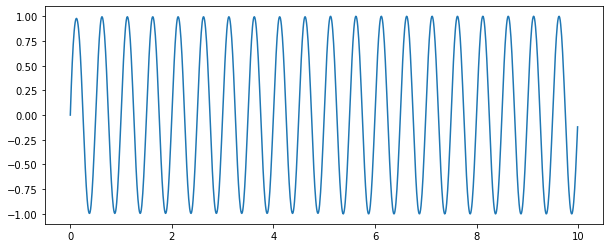

In [42]:
grid_dx = 10/da.x.size
grid_x = np.mgrid[0:10:grid_dx]

interpolated_da = griddata(da.x, da.values, grid_x, method='cubic')
plt.figure(figsize=(10,4))
plt.plot(grid_x, interpolated_da)

In [43]:
da.x.shape == da.values.shape == grid_x.shape

True

In [44]:
xrI_da = xr.DataArray(interpolated_da, coords=[grid_x], dims="x")
fftI_da = xrft.fft(xrI_da, dims="x", true_phase=True, true_amplitude=True)

(-10.0, 10.0)

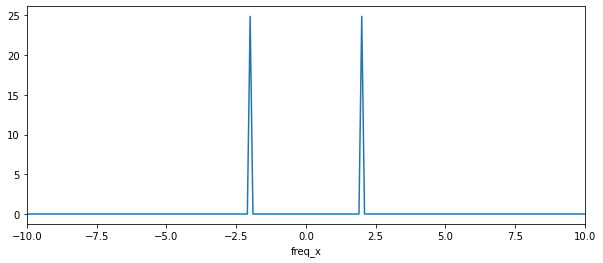

In [45]:
(fftI_da*np.conj(fftI_da)).real.plot(figsize=(10,4))
plt.xlim(-10,10)

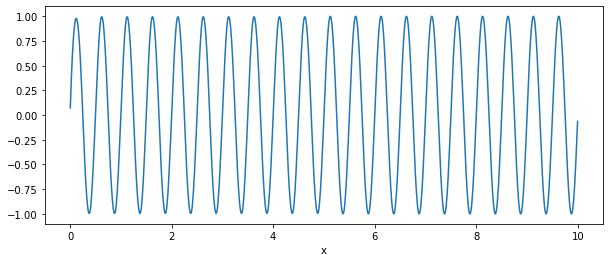

In [46]:
fft2_da = xrft.ifft(fftI_da, dim='freq_x', true_phase=True, true_amplitude=True, lag=5)
fft2_da.real.plot(figsize=(10,4))

# Try plotting some stuff

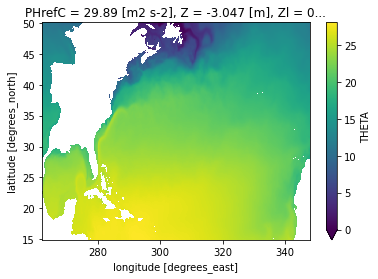

In [11]:
Tb.isel(time=0).where(dst.maskInC!=False).plot(rasterized=True, vmin=0)

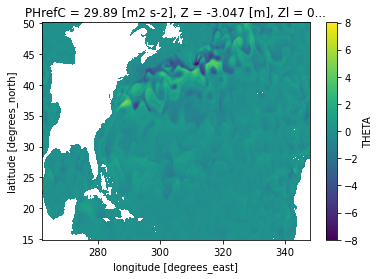

In [13]:
Tp.isel(nmemb=0,time=0).where(dst.maskInC!=False).plot(rasterized=True, cmap="viridis")

The ensemble mean field is much smoother than the residual. What does the mean and eddy part represent (statistically and physically)?

## Let's try masking out the land

In [ ]:
Tp.isel(nmemb=0,time=0).where(dst.maskInC!=0.).plot(rasterized=True)

## Can we zoom into the Gulf Stream?

In [ ]:
Tp.isel(nmemb=0,time=0).where(dst.maskInC!=0.).sel(YC=slice(35,45),XC=slice(280,330)).plot(rasterized=True)

## More flexibility in the plot

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
im = ax.pcolormesh(Tp.XC.sel(XC=slice(280,330)), Tp.YC.sel(YC=slice(30,50)), 
                   Tp.isel(nmemb=0,time=2).where(dst.maskInC!=0.).sel(YC=slice(30,50),XC=slice(280,330)),
                   cmap='seismic', vmax=6, vmin=-6
                  )
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label(r"[$^\circ$C]", fontsize=12)

In [ ]:
Tvar.where(dst.maskInC!=0.).isel(time=0).plot()

In [ ]:
Tlower = Tb - 2*Tstd 
Tupper = Tb + 2*Tstd

Test1 = dst.THETA - Tlower
Test2 = dst.THETA - Tupper
Test3 = dst.THETA - Tlower - Tupper

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
im = ax.pcolormesh(Test1.XC.sel(XC=slice(280,330)), Test1.YC.sel(YC=slice(30,50)), 
                   Test1.isel(nmemb=0,time=2).where(dst.maskInC!=0.).sel(YC=slice(30,50),XC=slice(280,330)),
                   cmap='seismic', vmax=6, vmin=-6
                  )
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label(r"[$^\circ$C]", fontsize=12)

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
im = ax.pcolormesh(Test2.XC.sel(XC=slice(280,330)), Test2.YC.sel(YC=slice(30,50)), 
                   Test2.isel(nmemb=0,time=2).where(dst.maskInC!=0.).sel(YC=slice(30,50),XC=slice(280,330)),
                   cmap='seismic', vmax=6, vmin=-6
                  )
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label(r"[$^\circ$C]", fontsize=12)

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
im = ax.pcolormesh(Test3.XC.sel(XC=slice(280,330)), Test3.YC.sel(YC=slice(30,50)), 
                   Test3.isel(nmemb=0,time=2).where(dst.maskInC!=0.).sel(YC=slice(30,50),XC=slice(280,330)),
                   cmap='seismic', vmax=10, vmin=-10
                  )
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label(r"[$^\circ$C]", fontsize=12)

## Movie

In [23]:
# Create movie object
#mov = Movie(Tp.sel(nmemb=0).where(dst.maskInC!=0.), vmin=-6, vmax=6, cmap='viridis')
#mov = Movie(Tvar.where(dst.maskInC!=0.), vmin=0, vmax=24, cmap='viridis')
#mov = Movie(W_smap.mean('nmemb'), cmap='viridis', vmin=0, vmax=20)
mov = Movie(WPSpectra.mean('nmemb'), cmap='viridis', vmax=10e0, vmin=10e-6)

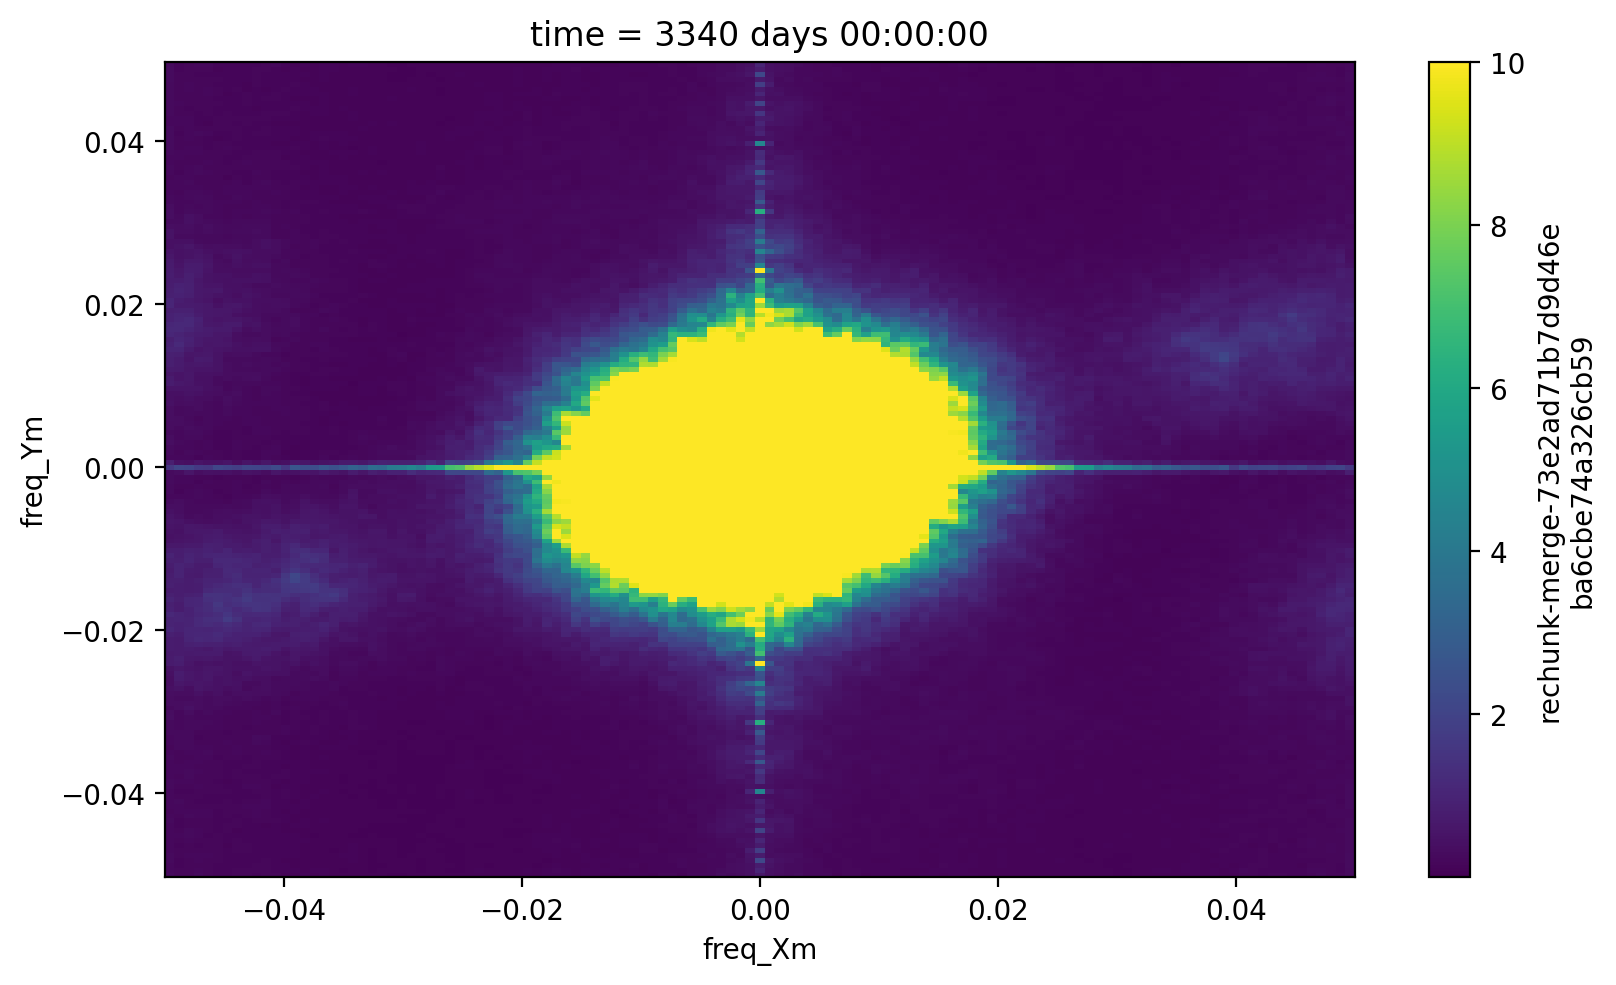

In [24]:
mov.preview(10)

In [25]:
mov.save(op.join(savedir,'movie_slow.mp4'), remove_movie=False, progress=True, framerate=5, gif_framerate=5, overwrite_existing=True)

100%|██████████| 36/36 [02:20<00:00,  3.89s/it]


Movie created at movie_slow.mp4


Python has really good documentation (e.g. [Matplotlib](https://matplotlib.org/stable/)) and Googling will be your new best friend. I often Google myself.